In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer


import sys
sys.path.append("../..")
from util.author_vis import t_sne, pca
from util.clustering_eval import clustering_summary, print_clustering_classes

In [2]:
test_data = pd.read_pickle('../../data/04c_Test_Set.pkl')

# Sentence BERT

In this third baseline notebook, the SBERT is used, that is also used in the final model.

In [3]:
messages = test_data["message"].tolist()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

vectors = model.encode(messages, convert_to_numpy=True)

## Centroids

In [4]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [5]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.320,0.277,0.544,0.266,0.375,0.324
1,0.000,0.000,0.310,0.582,0.317,0.399,0.332
2,0.000,0.000,0.000,0.570,0.202,0.271,0.244
3,0.000,0.000,0.000,0.000,0.584,0.621,0.571
4,0.000,0.000,0.000,0.000,0.000,0.289,0.213
5,0.000,0.000,0.000,0.000,0.000,0.000,0.201
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

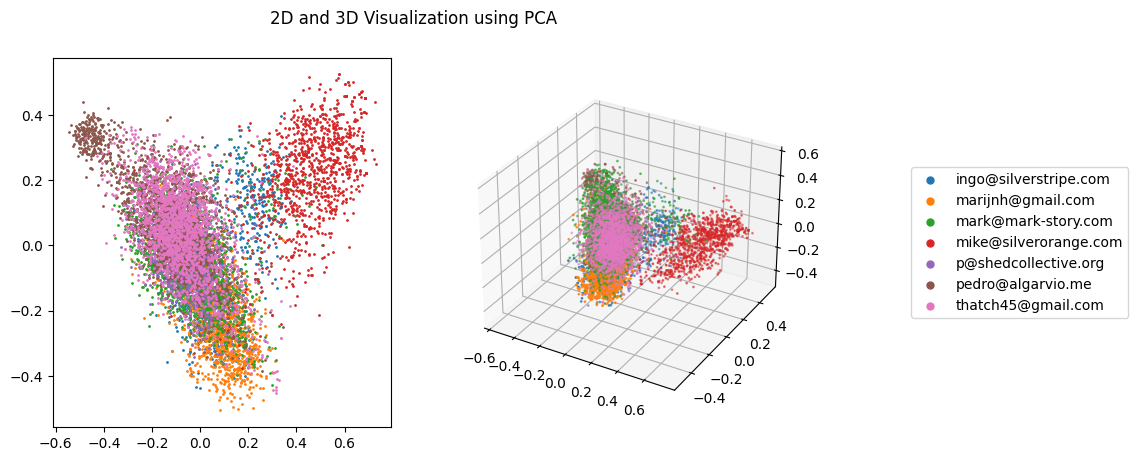

In [6]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

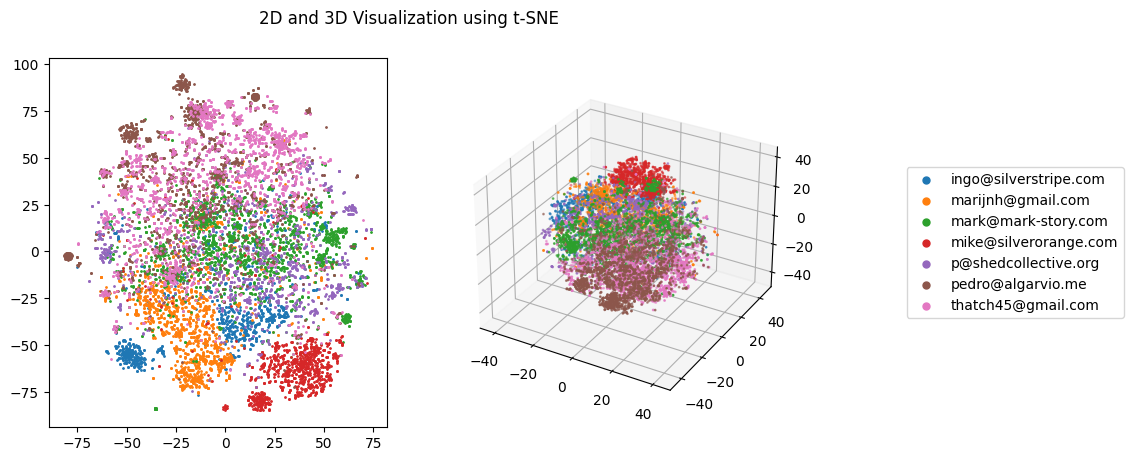

In [7]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

It can be seen that many SpaCy representations are similar and might be difficult to cluster. 

Anyways, below we try a density-based DBSCAN clustering and a centroid-based K-Means clustering to see if we can find clusters in the data.

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 2
10 Most common:
[(0, 5449), (-1, 5235)]


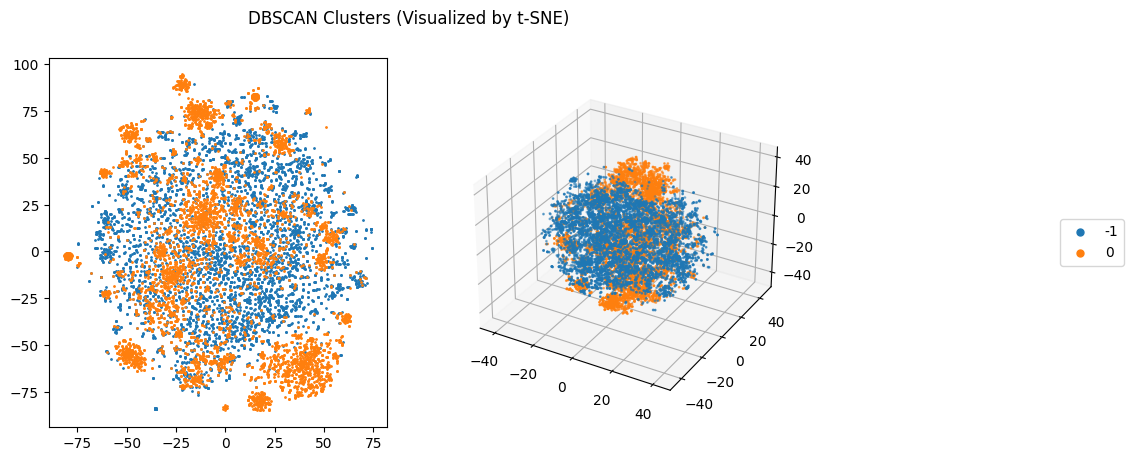

In [16]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [9]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,10684.0,7.0,1526.285714,"('mark@mark-story.com', 2082)",91.0,117.406593,"('saltstack_salt', 3798)"


In [10]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,1.0,1.0,1.000000,1.0,1.000000
mean,10684.0,7.0,1526.285714,91.0,117.406593
std,NaN,NaN,NaN,NaN,NaN
min,10684.0,7.0,1526.285714,91.0,117.406593
25%,10684.0,7.0,1526.285714,91.0,117.406593
50%,10684.0,7.0,1526.285714,91.0,117.406593
75%,10684.0,7.0,1526.285714,91.0,117.406593
max,10684.0,7.0,1526.285714,91.0,117.406593


In [11]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
3) 
MINOR Protection against infinite initialization/callback loops caused by loading a full page template via ajax (in LeftAndMain.js)
___
4) 
Allowing success and error callbacks in refresh()
___
5) 
Better shell execution feedback from PDF extractor
___
6) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
7) 
Added iShouldSeeAButton assertion
___
8) 
MINOR ArrayLib - removed unncessary extending of Objec

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(4, 2888), (2, 2294), (3, 1609), (6, 1316), (0, 1051), (1, 896), (5, 630)]


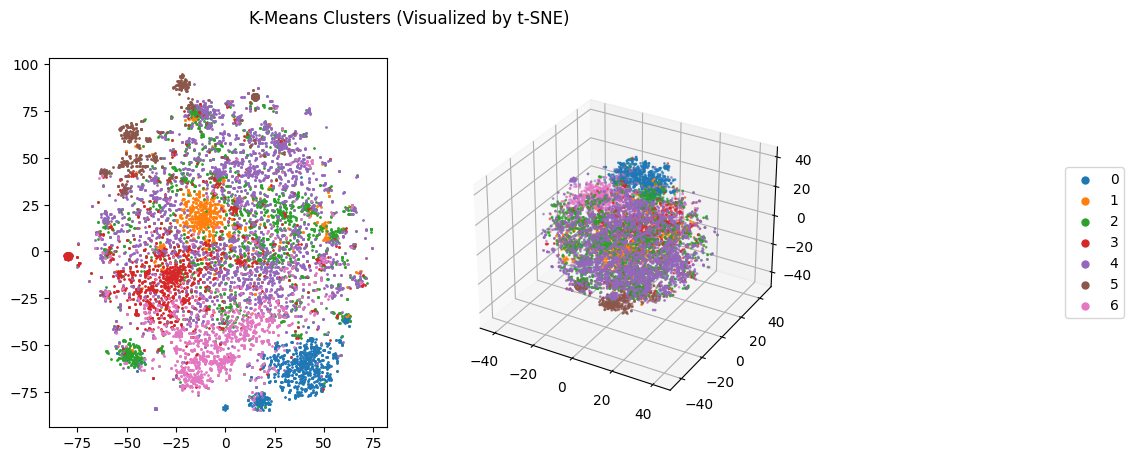

In [12]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [13]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,1051.0,7.0,150.142857,"('mike@silverorange.com', 971)",8.0,131.375000,"('silverorange_swat', 971)"
1,896.0,7.0,128.000000,"('mark@mark-story.com', 462)",34.0,26.352941,"('cakephp_cakephp', 450)"
2,2294.0,7.0,327.714286,"('mark@mark-story.com', 622)",69.0,33.246377,"('saltstack_salt', 831)"
3,1609.0,7.0,229.857143,"('marijnh@gmail.com', 451)",51.0,31.549020,"('saltstack_salt', 556)"
4,2888.0,7.0,412.571429,"('thatch45@gmail.com', 1040)",72.0,40.111111,"('saltstack_salt', 1467)"
5,630.0,4.0,157.500000,"('pedro@algarvio.me', 500)",8.0,78.750000,"('saltstack_salt', 610)"
6,1316.0,7.0,188.000000,"('marijnh@gmail.com', 685)",46.0,28.608696,"('codemirror_CodeMirror', 577)"


In [14]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.571429,227.683673,41.142857,52.856163
std,808.413820,1.133893,105.391559,26.130624,39.002208
min,630.000000,4.000000,128.000000,8.000000,26.352941
25%,973.500000,7.000000,153.821429,21.000000,30.078858
50%,1316.000000,7.000000,188.000000,46.000000,33.246377
75%,1951.500000,7.000000,278.785714,60.000000,59.430556
max,2888.000000,7.000000,412.571429,72.000000,131.375000


In [15]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
BUGFIX still use the correct methods to get a value, even if we're generating a CSV ($xmlSafe = false) (from r<I>) (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
MINOR Removed File->setField(), doesn't have any overloaded functionality (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
3) 
API CHANGE Removed BaseForm javascript class, was never used in core

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/cms/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
4) 
MINOR Re-added LeftAndMain->EditForm() as a complement to getEditForm() - it is necessary for form submissions as well as for template getters

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/cms/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
5) 
elofgren: